In [583]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Distributed estimation of the centroid and the ascending direction -
"""
!python -V || python3 -V

8184.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Python 3.13.1


In [584]:
# If executed from Google Colab --------------------------------------------------------
# !git clone https://github.com/jesusBV20/source_seeking_distr.git
# !rsync -a source_seeking_distr/ .
# !rm -r source_seeking_distr

# If you want to use latex with matplotlib ---------------------------------------------
# !apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !pip install -y latex

In [585]:
import numpy as np
import os
import csv
import ast
import xml.etree.ElementTree as ET
import re
import sys
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from scipy import stats as st

# Graphic tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter, FFMpegWriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# --------------------------------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Scalar field functions
from sourceseeking_distr.scalar_field.sigma_funcs import SigmaGauss, SigmaNonconvex, SigmaFract 

# Main utility functions used along the notebook
from sourceseeking_distr.toolbox.math_utils import XY_distrib, gen_random_graph, gen_Z_split
from sourceseeking_distr.toolbox.basic_utils import createDir
from sourceseeking_distr.toolbox.plot_utils import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from sourceseeking_distr.toolbox.math_utils import unit_vec, L_sigma



# --------------------------------------------------------------------------------------

# Create the output directory
OUTPUT_FOLDER = os.path.join("..","output")
createDir(OUTPUT_FOLDER)

The directory '../output' already exists!


In [586]:

class SSconSim:
    def __init__(self, k_asc, k_cen, device_n, iter_n):
        self.device_n = device_n
        self.k_asc = k_asc	
        self.k_cen = k_cen
        self.iter_n = iter_n
        self.com_graph = np.array([[0,1,0],
                                   [1,0,1],
                                   [0,1,0]])

    def set_conf_vals(self, k_asc, k_cen, iter_n):
        self.k_asc = k_asc	
        self.k_cen = k_cen
        self.iter_n = iter_n
  
    def calc_asc_at_step(self, steps, centroids, sigmas):
        if (any(steps) > self.iter_n+1 or any(steps) < 0):
            steps = [self.iter_n]*len(steps) # TODO
        step = max(steps)+1
                
        assert(len(centroids) == self.device_n and len(sigmas) == self.device_n and step >= 0)
        
        asc_dirs = np.zeros((step, self.device_n, self.device_n, 2))
        
        for dev in range(self.device_n):
            asc_dirs[0, dev, dev] = centroids[dev] * sigmas[dev]
        
        for i in range(step):
            prev_asc_dirs = asc_dirs[i-1].copy() if i >0 else asc_dirs[0].copy()
            for s_dev in range(self.device_n):
                for p_dev in range(self.device_n):
                    if (self.com_graph[s_dev, p_dev] == 1):
                        asc_dirs[i, s_dev, p_dev] = prev_asc_dirs[p_dev, p_dev]
                    else:
                        asc_dirs[i, s_dev, p_dev] = prev_asc_dirs[s_dev, s_dev]
                
                asc_dir_sum = np.zeros((2))    
                for dev in range(self.device_n):
                    asc_dir_sum += asc_dirs[i, s_dev, s_dev] - asc_dirs[i, s_dev,dev]
                    
                asc_dirs[i, s_dev, s_dev] += -self.k_asc * asc_dir_sum
        
        asc_dirs_ret = np.zeros((self.device_n, 2))
        
        for s_dev in range(self.device_n):
            asc_dirs_ret[s_dev] = asc_dirs[steps[s_dev], s_dev, s_dev]
            
        # Normalize asc_dirs_ret to unit vectors
        asc_dirs_ret = asc_dirs_ret / np.linalg.norm(asc_dirs_ret, axis=1, keepdims=True)
        
        return asc_dirs_ret
    
    def calc_cen_at_step(self, steps, pos):
        if (any(steps) > self.iter_n+1 or any(steps) < 0):
            steps = [self.iter_n]*len(steps)
        step = max(steps)+1
        
        assert(len(pos) == self.device_n and step >= 0)
        
        centroids = np.zeros((step, self.device_n, self.device_n, 2))
        
        pos_sum = np.zeros((self.device_n, 2))
        for s_dev in range(self.device_n):
            for p_dev in range(self.device_n):
                pos_sum[s_dev] += pos[s_dev] - pos[p_dev]
        
        for s_dev in range(self.device_n):
            cen_sum = np.zeros((2))    
            for dev in range(self.device_n):
                cen_sum += centroids[0, s_dev, s_dev] - centroids[0, s_dev,dev]
            centroids[0, s_dev, s_dev] += -self.k_cen * (cen_sum - pos_sum[s_dev])
        
        for i in range(step):
            prev_centroids = centroids[i-1].copy() if i >0 else centroids[0].copy()
            for s_dev in range(self.device_n):
                for p_dev in range(self.device_n):
                    if (self.com_graph[s_dev][p_dev] == 1):
                        centroids[i, s_dev, p_dev] = prev_centroids[p_dev, p_dev]
                    else:
                        centroids[i, s_dev, p_dev] = prev_centroids[s_dev, s_dev] - (pos[s_dev] - pos[p_dev])
                        
                cen_sum = np.zeros((2))
                for dev in range(self.device_n):
                    cen_sum += centroids[i, s_dev, s_dev] - centroids[i, s_dev,dev]
                centroids[i, s_dev, s_dev] += -self.k_cen * (cen_sum - pos_sum[s_dev])
        
        centroids_ret = np.zeros((self.device_n, 2))
        for s_dev in range(self.device_n):
            centroids_ret[s_dev] = centroids[steps[s_dev], s_dev, s_dev]
        
        return centroids_ret

### Consensus tests

In [587]:
def asc_tests(dev_n, b_step, end_step, seq_step, b_k, end_k, seq_k, centroids_array, sigmas_array, comp_cens):
    res_array = np.zeros((centroids_array.shape[0], dev_n, int((end_step - b_step)/seq_step), int((end_k - b_k)/seq_k)))
    for i, calc_pair in enumerate(zip(centroids_array, sigmas_array)):
        gt_val = np.average(calc_pair[0]*calc_pair[1][:,np.newaxis], axis=0) / np.linalg.norm(np.average(calc_pair[0]*calc_pair[1][:,np.newaxis], axis=0))
        for step_i in range(b_step, end_step, seq_step):
            for k_i in range(b_k, end_k, seq_k):
                sim = SSconSim(k_i/100, k_i/100, dev_n, end_step+1)
                calc_dirs = sim.calc_asc_at_step(np.full((3), step_i), calc_pair[0], calc_pair[1])
                res_array[i,:,(step_i-b_step)//seq_step,(k_i-b_k)//seq_k] = [np.acos(np.dot(val, gt_val)) for val in calc_dirs]
                
    return res_array
                

# Filter

In [588]:
def mask_rows_with_outliers(array, z_threshold):
    """
    Creates a mask for the first axis of the array where True indicates the row
    contains no outliers and False indicates at least one outlier is present.

    Parameters:
    array (numpy.ndarray): Input array of any shape.
    z_threshold (float): Z-score threshold for identifying outliers.

    Returns:
    numpy.ndarray: A 1D boolean mask with True for rows without outliers and False otherwise.
    """
    # Flatten the array to compute global mean and standard deviation
    flat_array = array.ravel()
    non_nan_mask = ~np.isnan(flat_array)
    valid_values = flat_array[non_nan_mask]
    
    # Calculate global mean and std for valid (non-NaN) values
    mean = np.mean(valid_values)
    std = np.std(valid_values)
    
    # Initialize an empty mask for each row
    mask = np.ones(array.shape[0], dtype=bool)

    for i in range(array.shape[0]):
        row = array[i]
        non_nan_row_mask = ~np.isnan(row)
        valid_row_values = row[non_nan_row_mask]

        if valid_row_values.size == 0:
            mask[i] = False  # If the row is entirely NaN, mark as False
            continue

        # Compute Z-scores for the row values based on global mean and std
        z_scores = (valid_row_values - mean) / std

        # If any value in the row is an outlier, mark the entire row as False
        if np.any(np.abs(z_scores) >= z_threshold):
            mask[i] = False

    return mask

In [589]:
def plot_3d_surface(data, x_scale=None, y_scale=None):
    """
    Create a 3D surface plot from a 2D numpy array.
    
    Parameters:
    data (numpy.ndarray): 2D array where the value at each position represents the height (z)
    x_scale (array-like, optional): Custom x-coordinates. Must match the number of rows in data
    y_scale (array-like, optional): Custom y-coordinates. Must match the number of columns in data
    
    Returns:
    matplotlib.figure.Figure: The generated figure
    """
    rows, cols = data.shape
    
    # Create coordinate matrices for x and y
    if x_scale is None:
        x_scale = np.arange(0, rows, 1)
    if y_scale is None:
        y_scale = np.arange(0, cols, 1)
        
    # Validate dimensions
    if len(x_scale) != rows or len(y_scale) != cols:
        raise ValueError("x_scale and y_scale must match the dimensions of the data array")
    
    X, Y = np.meshgrid(y_scale, x_scale)
    
    # Create the figure and 3D axes
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create the surface plot
    surface = ax.plot_surface(X, Y, data, 
                            cmap='viridis',
                            linewidth=0,
                            antialiased=True)
    
    # Add labels and a color bar
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value (Z)')
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
    
    return fig

## Centroid estimation

In [590]:

from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist
from matplotlib.animation import FuncAnimation

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, k=1):
    xhat_dt = - k*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

def anim_centroid_estimation(ss_dat, Z, N, fps=30):
    """
    Funtion to animate the centroid estimation
    """
    
    P = ss_dat["DWSS_DATA:pos"]
    P_l = ss_dat["DWSS_DATA:last_pos"]
    S = ss_dat["DWSS_DATA:sigma"]
    C = ss_dat["DWSS_DATA:centroid"]
    C_l = ss_dat["DWSS_DATA:last_centroid"]
    mu = ss_dat["DWSS_DATA:asc_dir_norm"]
    Ste = ss_dat["DWSS_DATA:step"]
    
    outlier_mask = mask_rows_with_outliers(C, 2)
        
    P = P[outlier_mask]
    P_l = P_l[outlier_mask]
    S = S[outlier_mask]
    C = C[outlier_mask]
    C_l = C_l[outlier_mask]
    Ste = Ste[outlier_mask]
    mu = mu[outlier_mask]
    
    S_color = S[:,:][S>0]
    S_color = S_color[S_color<1e5]
    s_mask = mask_rows_with_outliers(S_color, 1)
    S_color = S_color[s_mask]
    s_max = np.max(S_color)
    s_min = np.min(S_color[S_color>1e-5])
    # s_min = 0
    
    # Simulation -------------------------------------------------------
    
    pc_hat = P-C
                
    # Precalculated ----------------------------------------------------
    
    pc_comp = np.average(P, axis=1)
    pcl_comp = np.average(P_l, axis=1)
    c_comp = P_l-pcl_comp[:,np.newaxis,:]
    
    pc_sim = np.zeros_like(pc_hat)
    mu_sim = np.zeros_like(mu)
    mu_comp = np.zeros_like(pc_comp)
    
    sim = SSconSim(ss_dat["DWSS_DATA:k_asc"][0,0], ss_dat["DWSS_DATA:k_cen"][0,0], N, ss_dat["DWSS_DATA:iter_n"][0,0])
        
    for i, data_point in enumerate(P):
        sim.set_conf_vals(ss_dat["DWSS_DATA:k_asc"][i,0], ss_dat["DWSS_DATA:k_cen"][i,0], ss_dat["DWSS_DATA:iter_n"][i,0])
        pc_sim[i] = sim.calc_cen_at_step(Ste[i], data_point)
        mu_sim[i] = sim.calc_asc_at_step(Ste[i], C_l[i], S[i])
        mu_comp[i] = np.average(c_comp[i]*S[i][:,np.newaxis], axis=0)
        mu_comp[i] = mu_comp[i] / np.linalg.norm(mu_comp[i], keepdims=True)
        
    pc_sim = P-pc_sim
    mu_comp = np.repeat(mu_comp[:, np.newaxis, :], 3, axis=1)
    
    # mu_field = np.array([5,25])
    # A = np.eye(2)
    # sigma_test = SigmaGauss(mu=mu_field, max_intensity=2000, dev=30)
    # sigma_test.A = A
    
    # S_comp = np.apply_along_axis(sigma_test.eval_value, axis=2, arr=P)
    # S_comp = S_comp[:,:,0]
     
    mu_err = np.arccos(np.einsum('ijk,ijk->ij', mu, mu_comp))
    mu_sim_err = np.arccos(np.einsum('ijk,ijk->ij', mu_sim, mu_comp))
    c_err = pc_hat - np.broadcast_to(pc_comp[:, np.newaxis, :], pc_hat.shape)
    # c_err = np.linalg.norm(c_err, axis=2)
    c_err = np.log(np.linalg.norm(c_err, axis=2))
    
    c_l_err = P_l - C_l - np.broadcast_to(pc_comp[:, np.newaxis, :], pc_hat.shape)
    # c_err = np.linalg.norm(c_err, axis=2)
    c_l_err = np.log(np.linalg.norm(c_l_err, axis=2))

    # ------------------------------------------------------------------

    # -- Error plot --
    fig_err = plt.figure()
    ax_mu_err, ax_mu_sim_err, ax_c_err = fig_err.subplots(3,1)

    # Axis configuration
    ax_c_err.grid(True)
    ax_mu_err.grid(True)
    ax_mu_sim_err.grid(True)

    ax_c_err.set_xlabel("$T$")
    ax_c_err.set_ylabel("Centroid error (m)")
    ax_mu_err.set_xlabel("$T$")
    ax_mu_err.set_ylabel("L error(rad)")
    ax_mu_sim_err.set_xlabel("$T$")
    ax_mu_sim_err.set_ylabel("L error(rad)")

    # Lines
    ax_c_err.axhline(0, c="k", ls="-", lw=1.1)
    ax_c_err.axvline(0, c="k", ls="-", lw=1.1)
    ax_mu_err.axhline(0, c="k", ls="-", lw=1.1)
    ax_mu_err.axhline(np.pi/2, c="k", ls="-", lw=1.1)
    ax_mu_err.axvline(0, c="k", ls="-", lw=1.1)
    ax_mu_sim_err.axhline(0, c="k", ls="-", lw=1.1)
    ax_mu_sim_err.axhline(np.pi/2, c="k", ls="-", lw=1.1)
    ax_mu_sim_err.axvline(0, c="k", ls="-", lw=1.1)

    for i in range(P.shape[1]):
        ax_c_err.plot(c_err[:,i], label=i)
        ax_mu_err.plot(mu_err[:,i], label=i)
        ax_mu_sim_err.plot(mu_sim_err[:,i], label=i)

        ax_c_err.legend()

    # -- Animation --
    fig = plt.figure()
    ax = fig.subplots()
    
    ax.set_aspect("equal")
    ax.grid(True)

    title = "SS"
    ax.set_title(title)

    ax.set_xlabel("$Y$ [L]")
    ax.set_ylabel("$X$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)
    
    # sigma_test.draw(fig=fig, ax=ax, xlim=70, ylim=40, n=300, contour_levels=20)

    # Centroids
    pts = ax.scatter(pc_hat[0,:,0], pc_hat[0,:,1], color="r", marker=r"$x$", s=50)
    pts_sim = ax.scatter(pc_sim[0,:,0], pc_sim[0,:,1], color="y", marker=r"$x$", s=50, alpha=0.3)
    pts_comp = ax.scatter(pc_comp[0,0], pc_comp[0,1], color="b", marker=r"$x$", s=50, alpha=0.3)

    # Set up the normalization and colormap
    color_norm = mcolors.Normalize(vmin=s_min, vmax=s_max)
    cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red
    
    # Agents
    agts = ax.scatter(P[0,:,0], P[0,:,1], c=S[0,:], s=100, cmap=cmap, norm=color_norm)
            
    # Estimated ascending direction mu
    quivers = ax.quiver(P[0,:,0], P[0,:,1], mu[0,:,0], mu[0,:,1], color="r", angles='xy', scale_units='xy', scale=1)
    
    # Ascending direction simulated from centroid data
    quivers_sim = ax.quiver(P[0,:,0], P[0,:,1], mu_sim[0,:,0], mu_sim[0,:,1], color="y", angles='xy', scale_units='xy', scale=1, alpha=0.3)
    
    # Ascending direction computed from centroid data
    quivers_comp = ax.quiver(P[0,:,0], P[0,:,1], mu_comp[0,:,0], mu_comp[0,:,1], color="b", angles='xy', scale_units='xy', scale=1, alpha=0.3)
    
    agt_edges = []    
    for edge in Z:
        agt_edge, = ax.plot([P[0,edge[0]-1,0], P[0,edge[1]-1,0]], [P[0,edge[0]-1,1], P[0,edge[1]-1,1]], "k--")
        agt_edges.append(agt_edge)

    # -- Building the animation --
    anim_frames = C.shape[0]
    ann_list = []

    # Function to update the animation
    def animate(i):
        p_max = np.array([np.max(P[i,:,0]),np.max(P[i,:,1])])
        p_min = np.array([np.min(P[i,:,0]),np.min(P[i,:,1])])
        
        # Add padding (optional)
        padding = 0.5  # 10% padding
        x_range = p_max[0] - p_min[0]
        y_range = p_max[1] - p_min[1]
        lim_range = max(x_range, y_range)
        
        ax.set_xlim(p_min[0] - padding * lim_range, p_max[0] + padding * lim_range)
        ax.set_ylim(p_min[1] - padding * lim_range, p_max[1] + padding * lim_range)
        
        v_scale = np.linalg.norm(p_max-p_min)/3
        
        for ann in ann_list:
            ann.remove()
        ann_list.clear()
        
        # Update the centroid estimation markers
        pts.set_offsets(pc_hat[i])
        pts_sim.set_offsets(pc_sim[i])
        pts_comp.set_offsets(pc_comp[i])
        agts.set_offsets(P[i])
        agts.set_array(S[i,:])
        for agt_edge, edge in zip(agt_edges, Z):
            agt_edge.set_data([P[i,edge[0]-1,0], P[i,edge[1]-1,0]], [P[i,edge[0]-1,1], P[i,edge[1]-1,1]])
        
        quivers.set_offsets(P[i])
        quivers.set_UVC(mu[i,:,0]*v_scale, mu[i,:,1]*v_scale)
        
        quivers_sim.set_offsets(P[i])
        quivers_sim.set_UVC(mu_sim[i,:,0]*v_scale, mu_sim[i,:,1]*v_scale)
        
        quivers_comp.set_offsets(P[i])
        quivers_comp.set_UVC(mu_comp[i,:,0]*v_scale, mu_comp[i,:,1]*v_scale)
        
        # Step number
        for j, (x, y) in enumerate(P[i,:,:]):
            ann_list.append(ax.annotate(f"{j}:{ss_dat["DWSS_DATA:step"][i,j]}", (x, y), 
                        textcoords="offset points", xytext=(0,10), ha='center'))

    # Generate the animation
    print("Simulating {0:d} frames...".format(anim_frames))
    anim = FuncAnimation(fig, animate, frames=tqdm(range(anim_frames), initial=1, position=0), 
                         interval=1/fps*1000)
    anim.embed_limit = 40

    # Close plots and return the animation class to be compiled
    plt.close()
    return anim

## Data input

In [591]:
class SSReader:
    CSV_FIELDS = ("Time", "DWSS_DATA:step", "DWSS_DATA:last_pos", "DWSS_DATA:centroid", "DWSS_DATA:last_centroid", 
              "DWSS_DATA:asc_dir", "DWSS_DATA:asc_dir_norm", "DWSS_DATA:pos", "DWSS_DATA:sigma", "DWSS_DATA:iter_n", 
              "DWSS_DATA:k_cen", "DWSS_DATA:k_asc", "DWSS_DATA:field_offset")

    def __init__(self, dirpath: str):
        self.dirpath = dirpath
        self.data_dict = {}
        self.min_len = 9999999
        self.load_all_csv_in_folder()

    def parse_value(self, value):
        """
        Parse a string value as either a tuple of numbers or a single float.
        Returns default values in case of parsing errors.
        """
        try:
            # Check if the value contains a comma, indicating a point in space
            if ',' in value:
                # Attempt to parse as a tuple
                parsed_value = np.array(ast.literal_eval(f'({value})'))
                return parsed_value
            elif '.' in value:
                # Attempt to parse as a float
                return float(value)
            else:
                return int(value)
        except (ValueError, SyntaxError, TypeError):
            # Return default values in case of errors
            if ',' in value:
                return np.array([0.0, 0.0])  # Default for tuple values
            else:
                return 0.0  # Default for single float values

    def load_csv_to_dict(self, filename):
        """Load a CSV file into a dictionary with lists of parsed values."""
        data_dict = {}
        
        # Open the CSV file with tab delimiter
        with open(filename, mode='r') as csvfile:
            csvreader = csv.DictReader(csvfile, delimiter='\t')
            
            # Fill the dictionary with parsed data
            for row in csvreader:
                for header in csvreader.fieldnames:
                    if header in self.CSV_FIELDS:
                        if header not in data_dict:
                            data_dict[header] = []
                        data_dict[header].append(self.parse_value(row[header]))
        
        return data_dict

    def convert_dict_to_numpy_arrays(self, data_dict):
        """Convert lists in the dictionary to appropriate NumPy arrays or keep them as lists if necessary."""
        numpy_arrays = {}
        for key, value in data_dict.items():
            # Check if the list contains only scalars
            if all(isinstance(v, (float, int)) for v in value):
                numpy_arrays[key] = np.array(value)
            else:
                numpy_arrays[key] = np.vstack(value)
                
            if len(numpy_arrays[key]) < self.min_len:
                self.min_len = len(numpy_arrays[key])
        
        return numpy_arrays

    def load_all_csv_in_folder(self):
        # List all CSV files in the given folder
        for file_name in os.listdir(self.dirpath):
            if file_name.endswith('.csv'):
                # Get the full file path
                file_path = os.path.join(self.dirpath, file_name)
                
                # Load CSV data into a dictionary
                data_dict = self.load_csv_to_dict(file_path)
                
                # Convert the dictionary to appropriate NumPy arrays or lists
                numpy_arrays = self.convert_dict_to_numpy_arrays(data_dict)
                
                # Store the result in the self.data_dict dictionary, using the file name (without extension) as the key
                
                file_date, file_id = self.extract_date_and_id_from_filename(file_name)
                    
                if file_date not in self.data_dict:
                    self.data_dict[file_date] = {}
                
                if file_id not in self.data_dict[file_date]:
                    self.data_dict[file_date][file_id] = {}
                    
                self.data_dict[file_date][file_id] = numpy_arrays
                
    def extract_date_and_id_from_filename(self, filename):
        """Extract the date and ID from the filename in the format [date]_[time]_[id].csv."""
        match = re.match(r"(\d{2}_\d{2}_\d{2}__\d{2}_\d{2}_\d{2})_(\d+)", filename)
        if match:
            date = match.group(1)
            file_id = match.group(2)
            return date, file_id
        return None, None
    
    def align_dicts(self, timestamp_col='Time'):
        
        for file_date, devices in self.data_dict.items():
            for dev, dev_data in devices.items():
                self.data_dict[file_date][dev] = pd.DataFrame({col_name: list(dev_cols) for col_name, dev_cols in dev_data.items()})
                
            start_timestamp = max(df[timestamp_col].iloc[0] for df in devices.values())
            all_timestamps = pd.concat([df[timestamp_col] for df in devices.values()]).unique()
            all_timestamps = sorted(ts for ts in all_timestamps if ts >= start_timestamp)
            
            for dev, dev_data in devices.items():
                df = dev_data.sort_values(by=timestamp_col).reset_index(drop=True)
                full_df = pd.DataFrame({timestamp_col: all_timestamps})  # DataFrame with all timestamps
                
                # Merge original dataframe with the full timestamp dataframe
                merged_df = pd.merge_asof(
                    full_df, 
                    df, 
                    on=timestamp_col, 
                    direction='backward'  # Fill missing timestamps with the last available row
                )
                
                # print(merged_df)
                
                self.data_dict[file_date][dev] = {col: np.array(merged_df[col].tolist()) for col in merged_df.columns}
                
            self.min_len = len(self.data_dict[file_date]['1'][self.CSV_FIELDS[0]])
            for dev, dev_data in devices.items():
                if len(dev_data[self.CSV_FIELDS[0]]) < self.min_len:
                    self.min_len = len(dev_data[self.CSV_FIELDS[0]])
                

    def to_npa(self):
        npa_dict = {}
        for file_date, devices in self.data_dict.items():
            new_dict = {}
            for field_name in devices['1'].keys():
                if field_name in self.CSV_FIELDS:
                    # list_t = [dev[field_name][:self.min_len] for dev in devices.values()]
                    # print(list_t)
                    new_dict[field_name] = np.stack([dev[field_name][:self.min_len] for dev in devices.values()], axis=1)
        
        npa_dict[file_date] = new_dict    
        return npa_dict     
          
                        

In [592]:
ss_data =  SSReader("../input_data/")
ss_data.align_dicts()
ss_npa = ss_data.to_npa()

In [593]:
def remove_rows(data_dict, interval):
    """Removes rows from NumPy arrays in a dictionary.

    Args:
        data_dict: A dictionary where values are NumPy arrays of shape (n, ...).
        interval: An integer specifying the interval at which to remove rows.

    Returns:
        A new dictionary with the modified arrays.
    """

    new_dict = {}
    for key, value in data_dict.items():
        indices_to_keep = np.arange(value.shape[0]) % interval == 0
        new_dict[key] = value[indices_to_keep]
    
    return new_dict

In [594]:
to_anim_dat = ss_npa['24_09_13__12_09_10']
to_anim_dat = remove_rows(to_anim_dat, 8)

Mean: 49.293169877408054
Median: 37.0
Mode: 23
Standard Deviation: 84.83790997609056
Minimum: 20
Maximum: 2217


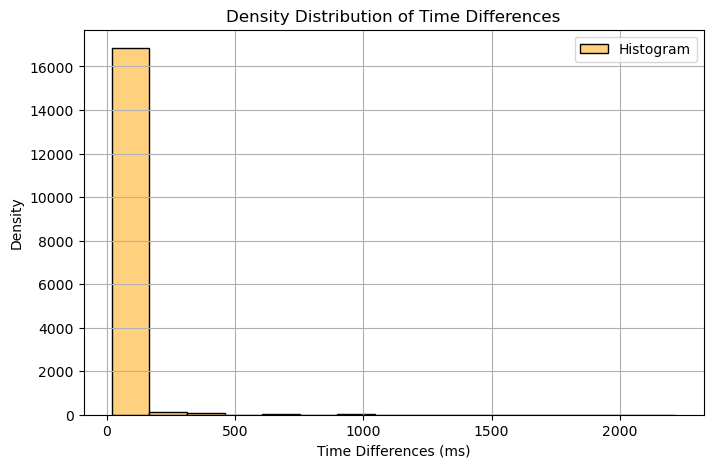

In [595]:
# WARNING Aling dict must be commented

ss_timestamps = ss_npa['24_09_13__12_09_10']["Time"]

# Calculate differences between consecutive timestamps
time_differences = [np.diff(ss_timestamps[:,dev]) for dev in range(ss_timestamps.shape[1])]
all_time_diff = np.concatenate(time_differences)

# Compute statistics
mean_diff = np.mean(all_time_diff)
median_diff = np.median(all_time_diff)
mode_diff = st.mode(all_time_diff).mode
std_diff = np.std(all_time_diff)
min_diff = np.min(all_time_diff)
max_diff = np.max(all_time_diff)

# Print the results
print(f"Mean: {mean_diff}")
print(f"Median: {median_diff}")
print(f"Mode: {mode_diff}")
print(f"Standard Deviation: {std_diff}")
print(f"Minimum: {min_diff}")
print(f"Maximum: {max_diff}")

# Step 2: Plot the density distribution using Seaborn
plt.figure(figsize=(8, 5))  # Set figure size
# sns.kdeplot(all_time_diff, fill=True, color="skyblue", label="Density")

# Optional: Histogram with the same plot
sns.histplot(all_time_diff, bins=15, kde=False, color="orange", alpha=0.5, label="Histogram")

# Add titles and labels
plt.title("Density Distribution of Time Differences")
plt.xlabel("Time Differences (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid()

# Display the graph
plt.show()

### Some examples

/tmp/ipykernel_6886/2184085462.py:49: RuntimeWarning: invalid value encountered in divide
  asc_dirs_ret = asc_dirs_ret / np.linalg.norm(asc_dirs_ret, axis=1, keepdims=True)
/tmp/ipykernel_6886/3173920189.py:78: RuntimeWarning: invalid value encountered in divide
  mu_comp[i] = mu_comp[i] / np.linalg.norm(mu_comp[i], keepdims=True)
/tmp/ipykernel_6886/3173920189.py:91: RuntimeWarning: invalid value encountered in arccos
  mu_err = np.arccos(np.einsum('ijk,ijk->ij', mu, mu_comp))
/tmp/ipykernel_6886/3173920189.py:95: RuntimeWarning: divide by zero encountered in log
  c_err = np.log(np.linalg.norm(c_err, axis=2))
/tmp/ipykernel_6886/3173920189.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red


Simulating 692 frames...


100%|█████████▉| 691/692 [00:39<00:00, 18.54it/s]

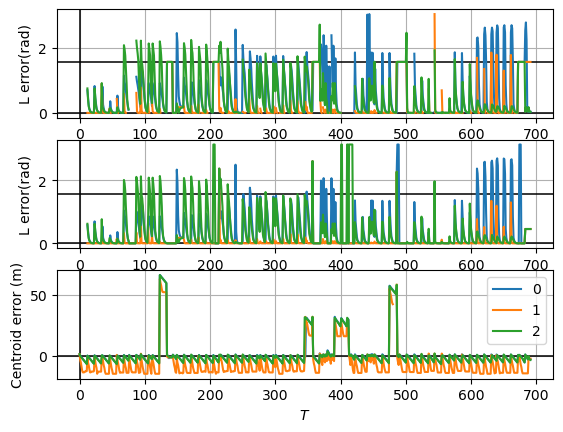

100%|█████████▉| 691/692 [00:54<00:00, 18.54it/s]

In [596]:

Z = ((1,2), (2,3))

# anim1 = anim_centroid_estimation(p, Z, c, l, s)
# HTML(anim1.to_html5_video())

anim2 = anim_centroid_estimation(to_anim_dat, Z, 3, fps=3)
# writer = FFMpegWriter(fps=5)
# anim2.save("animation.mp4", writer=writer)
HTML(anim2.to_html5_video())

# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "centroid1.gif"),
#         writer = writer)